In [3]:
import pandas

events = pandas.read_csv("dataset\\events.csv")
properties = pandas.concat(
    [
        pandas.read_csv("dataset\\item_properties_part1.csv"),
        pandas.read_csv("dataset\\item_properties_part2.csv")
    ],
    ignore_index=True
)
parents = pandas.read_csv("dataset\\category_tree.csv")


In [4]:
events.fillna({'transactionid': -1}, inplace=True)
events['timestamp'] = pandas.to_datetime(events['timestamp'], unit='ms')
events['event'] = events['event'].astype('category')
events.sort_values(by='timestamp', inplace=True)

properties.dropna(inplace=True)
properties['property'] = properties['property'].astype('category')
properties['value'] = properties['value'].astype('category')
properties['timestamp'] = pandas.to_datetime(properties['timestamp'], unit='ms')
properties.sort_values(by='timestamp', inplace=True)

parents.fillna({'parentid': -1}, inplace=True)
parents.drop_duplicates(inplace=True)

events.to_csv("prepared_dataset\\events.csv", index=False)
properties.to_csv("prepared_dataset\\properties.csv", index=False)
parents.to_csv("prepared_dataset\\parents.csv", index=False)

Events DataFrame Stats:
                            timestamp     visitorid        itemid  \
count                        2756101  2.756101e+06  2.756101e+06   
mean   2015-07-09 06:48:08.348103680  7.019229e+05  2.349225e+05   
min       2015-05-03 03:00:04.384000  0.000000e+00  3.000000e+00   
25%       2015-06-05 04:23:14.792000  3.505660e+05  1.181200e+05   
50%    2015-07-09 14:43:33.599000064  7.020600e+05  2.360670e+05   
75%       2015-08-10 16:45:05.168000  1.053437e+06  3.507150e+05   
max       2015-09-18 02:59:47.788000  1.407579e+06  4.668670e+05   
std                              NaN  4.056875e+05  1.341954e+05   

       transactionid  
count   2.756101e+06  
mean    7.092738e+01  
min    -1.000000e+00  
25%    -1.000000e+00  
50%    -1.000000e+00  
75%    -1.000000e+00  
max     1.767100e+04  
std     9.173903e+02  
Properties DataFrame Stats:
           timestamp        itemid
count  2.027590e+07  2.027590e+07
mean   1.435157e+12  2.333904e+05
std    3.327798e+09  1.3

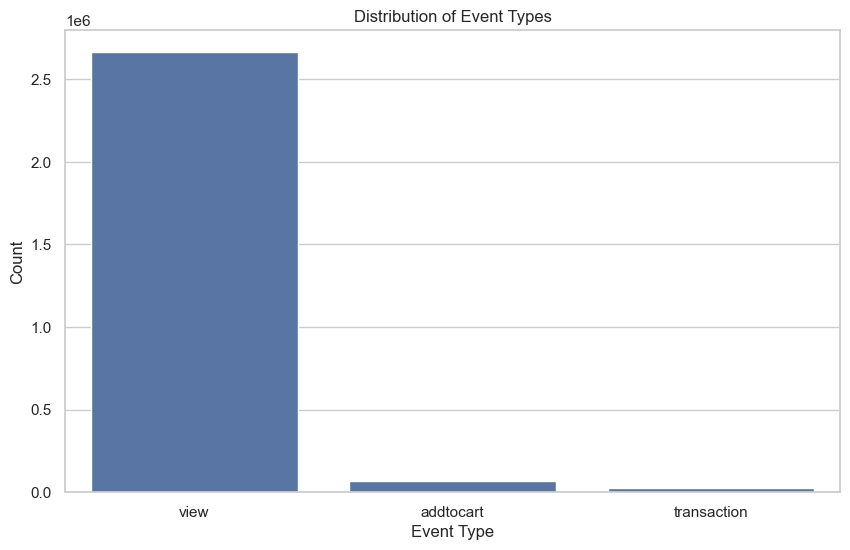

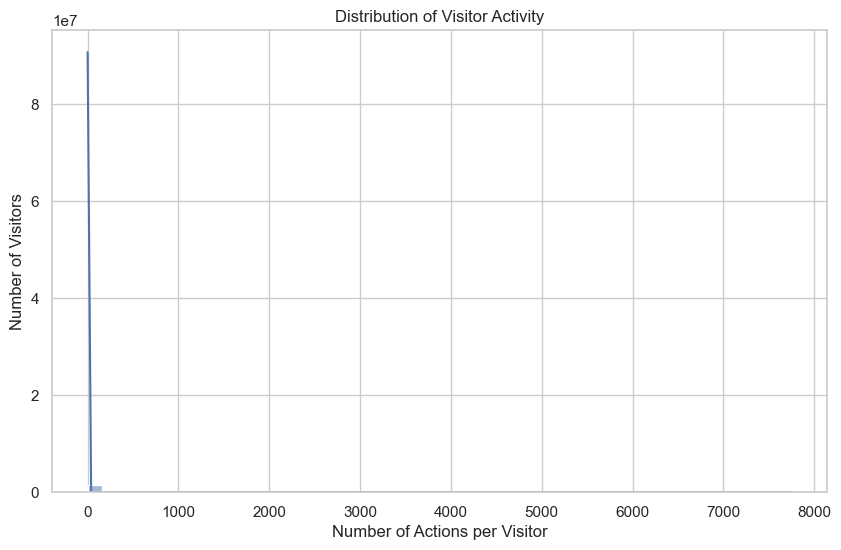

C:\Users\abhishek\AppData\Local\Temp\ipykernel_16748\2353797499.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily_events = events.groupby(['date', 'event']).size().unstack(fill_value=0)


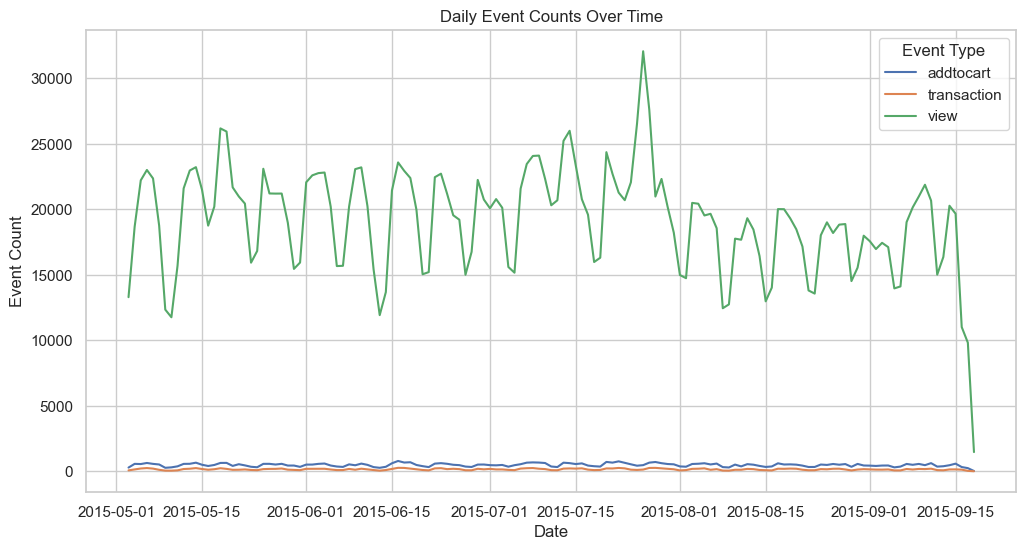

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

print("Events DataFrame Stats:\n", events.describe())
print("Properties DataFrame Stats:\n", properties.describe())
print("Parents DataFrame Stats:\n", parents.describe())

plt.figure(figsize=(10, 6))
sns.countplot(data=events, x='event', order=events['event'].value_counts().index)
plt.title("Distribution of Event Types")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.show()

visitor_counts = events['visitorid'].value_counts()
plt.figure(figsize=(10, 6))
sns.histplot(visitor_counts, bins=50, kde=True)
plt.title("Distribution of Visitor Activity")
plt.xlabel("Number of Actions per Visitor")
plt.ylabel("Number of Visitors")
plt.show()

events['date'] = events['timestamp'].dt.date  # Extract date for aggregation
daily_events = events.groupby(['date', 'event']).size().unstack(fill_value=0)
daily_events.plot(figsize=(12, 6))
plt.title("Daily Event Counts Over Time")
plt.xlabel("Date")
plt.ylabel("Event Count")
plt.legend(title="Event Type")
plt.show()

In [4]:
events_sorted = events.sort_values(by=['visitorid', 'itemid', 'timestamp'])

def funnel_analysis(df):
    funnel_data = {'view_to_cart': 0, 'cart_to_purchase': 0, 'full_funnel': 0}

    for _, group in df.groupby(['visitorid', 'itemid']):
        group = group.reset_index(drop=True)
        
        view_idx = group[group['event'] == 'view'].index
        cart_idx = group[group['event'] == 'addtocart'].index
        purchase_idx = group[group['event'] == 'transaction'].index

        for v_idx in view_idx:
            for c_idx in cart_idx:
                if c_idx > v_idx and (group.loc[c_idx, 'timestamp'] - group.loc[v_idx, 'timestamp']).days <= 7:
                    funnel_data['view_to_cart'] += 1
                    for p_idx in purchase_idx:
                        if p_idx > c_idx and (group.loc[p_idx, 'timestamp'] - group.loc[c_idx, 'timestamp']).days <= 7:
                            funnel_data['full_funnel'] += 1
                            funnel_data['cart_to_purchase'] += 1
                            break
                    break

    return funnel_data

funnel_results = funnel_analysis(events_sorted)
print("Funnel Analysis Results:", funnel_results)


Funnel Analysis Results: {'view_to_cart': 72147, 'cart_to_purchase': 28436, 'full_funnel': 28436}


In [5]:
events_sorted['session_id'] = (events_sorted.groupby('visitorid')['timestamp']
                               .diff().dt.total_seconds().gt(1800).cumsum())

def session_funnel_analysis(df):
    session_funnels = {'sessions': 0, 'complete_funnels_in_sessions': 0}
    
    for _, group in df.groupby(['visitorid', 'session_id']):
        session_funnels['sessions'] += 1
        
        if ('view' in group['event'].values and
            'addtocart' in group['event'].values and
            'transaction' in group['event'].values):
            session_funnels['complete_funnels_in_sessions'] += 1

    return session_funnels

session_results = session_funnel_analysis(events_sorted)
print("Session-Based Funnel Analysis Results:", session_results)

Session-Based Funnel Analysis Results: {'sessions': 1780279, 'complete_funnels_in_sessions': 15284}


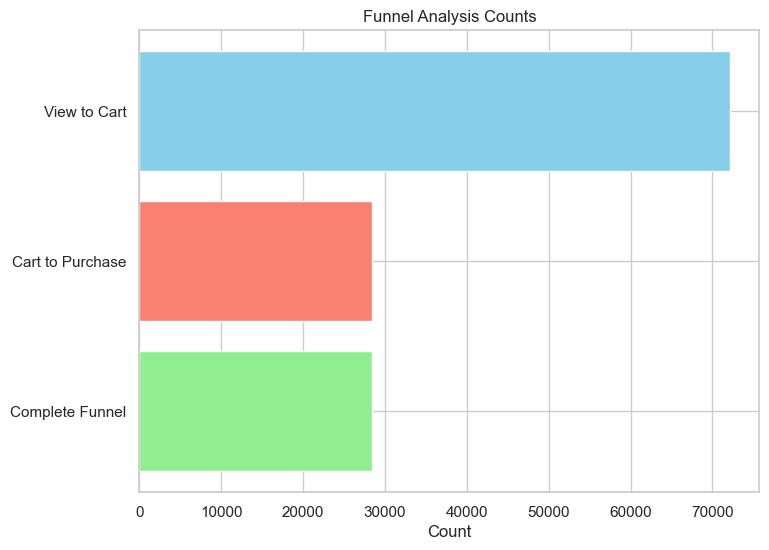

In [6]:
funnel_counts = [funnel_results['view_to_cart'], funnel_results['cart_to_purchase'], funnel_results['full_funnel']]
stages = ['View to Cart', 'Cart to Purchase', 'Complete Funnel']

plt.figure(figsize=(8, 6))
plt.barh(stages, funnel_counts, color=['skyblue', 'salmon', 'lightgreen'])
plt.xlabel("Count")
plt.title("Funnel Analysis Counts")
plt.gca().invert_yaxis()
plt.show()


In [7]:
'''
Effect of Item Category on Add-to-Cart Rate
    Goal: Examine if certain item categories are more likely to be added to the cart than others.
    Null Hypothesis: Add-to-cart rates are evenly distributed across item categories.
    Alternative Hypothesis: There is a significant difference in add-to-cart rates based on item category.
    Test: Chi-square test for goodness-of-fit.

    Output: Reject the Null Hypothesis (H₀). There is a statistically significant difference in add-to-cart rates among different item categories.
'''

from scipy.stats import chisquare

cart_by_category = properties[properties['itemid'].isin(events[events['event'] == 'addtocart']['itemid'])]
cart_by_category = cart_by_category[cart_by_category['property'] == 'categoryid']
category_counts = cart_by_category['value'].value_counts()

total_add_to_cart = category_counts.sum()
expected_frequencies = [total_add_to_cart / len(category_counts)] * len(category_counts)

chi2_stat, p_value = chisquare(f_obs=category_counts, f_exp=expected_frequencies)

if p_value < 0.05: print("Reject the Null Hypothesis (H₀). There is a statistically significant difference in add-to-cart rates among different item categories.")
else: print("Fail to Reject the Null Hypothesis (H₀). There is no statistically significant difference in add-to-cart rates among different item categories.")


Reject the Null Hypothesis (H₀). There is a statistically significant difference in add-to-cart rates among different item categories.


In [8]:
'''
Conversion Rate Comparison for New vs. Returning Users
    Goal: Check if new users are as likely to convert as returning users.
    Null Hypothesis: The conversion rate is the same for new and returning users.
    Alternative Hypothesis: The conversion rate is significantly different between new and returning users.
    Test: Z-test for two proportions.
'''

import numpy as np
from statsmodels.stats.proportion import proportions_ztest

new_user_conversions = 0
new_user_total = 0

returning_user_conversions = 0
returning_user_total = 0

events = events.sort_values(by='timestamp')

view_users = set()
purchased_users = set()

for idx, row in events.iterrows():
    visitor_id = row['visitorid']
    event_type = row['event']
    
    if event_type == 'view':
        if visitor_id not in view_users:
            view_users.add(visitor_id)
            new_user_total += 1
        else:
            returning_user_total += 1

    elif event_type == 'transaction':
        if visitor_id not in purchased_users:
            purchased_users.add(visitor_id)
            new_user_conversions += 1
        else:
            returning_user_conversions += 1

count = np.array([new_user_conversions, returning_user_conversions])
nobs = np.array([new_user_total, returning_user_total])
z_stat, p_value = proportions_ztest(count, nobs)

alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject the Null Hypothesis (H₀). There is a significant difference in conversion rates between new and returning users.")
else:
    print("Fail to Reject the Null Hypothesis (H₀). There is no significant difference in conversion rates between new and returning users.")

Fail to Reject the Null Hypothesis (H₀). There is no significant difference in conversion rates between new and returning users.
